# T-S diagrams and comparison

For reference: https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/TemperatureSalinityDiagrams.ipynb

In [1]:
import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import numpy as np
import xarray as xr
from distributed.diagnostics.progressbar import progress
import cosima_cookbook as cc
import cmocean as cmo

import matplotlib.pyplot as plt
import gsw

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
from dask.distributed import Client
client = Client()
display(client)

<Client: 'tcp://127.0.0.1:36861' processes=5 threads=20, memory=128.00 GiB>

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'
# idem as GPC013 but gade line formulation
Tfreezing_min_calv_2_gade = 'accessom2-GPC015'

start_time='2152-01-01'
end_time='2153-01-01'

lat_slice = slice(-80,-59)
lon_slice = slice(-280,80)
#isobath_depth = 1000

In [4]:
# build database for basal melt experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

# dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
#            '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC015/']
# cc.database.build_index(dir_list,basal_melt_session)

Get bathymetry. 

In [5]:
# get bathymetry
ht = cc.querying.getvar(control, 'ht', master_session, n=-1).sel(yt_ocean=lat_slice)

Define functions to read in data from control and simulation

In [10]:
def read_and_convert_TS(lat_slice, lon_slice, start_time, end_time):
    '''
    Reads T and S from control and Tfreeze_min simulation
    Restricts to shelf and region given by lat_slice and lon_slice
    Convert TS using gsw
    '''
    
    # control run
    temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    
    ## temp_Tfreezing_min_calv_2 run
    #temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp', basal_melt_session, frequency='1 monthly',
    #                                      start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    #salt_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'salt', basal_melt_session, frequency='1 monthly',
    #                                      start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    
    # temp_gade run
    temp_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

    # subset temp and salinity only for shelf values
    temp = temp.where(ht<1000)
    salt = salt.where(ht<1000)
    #temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.where(ht<1000)
    #salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.where(ht<1000)
    temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade.where(ht<1000)
    salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.where(ht<1000)
    
    # interpolate to evenly spaced 50 m vertical grid and load data
    z_even = np.arange(0,1050,50)
    salt = salt.interp(st_ocean = z_even).load()
    temp = temp.interp(st_ocean = z_even).load()
    #salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.interp(st_ocean = z_even).load()
    #temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.interp(st_ocean = z_even).load()
    salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.interp(st_ocean = z_even).load()
    temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade.interp(st_ocean = z_even).load()

    # subset for first region and load data
    #temp = temp.load()
    #salt = salt.load()
    #temp_Tf_min_s0 = temp_Tf_min_s0.load()
    #salt_Tf_min_s0 = salt_Tf_min_s0.load()
    print('Temp is' , temp.nbytes/1000**3, 'GB')
    
    # convert Temp to deg C
    temp = temp - 273.15
    #temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2 - 273.15
    temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade - 273.15
    # convert salinity to absolute salinity
    p = gsw.p_from_z(-salt.st_ocean,salt.yt_ocean)
    salt = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
    #salt_Tfreezing_min_calv_2 = gsw.SA_from_SP(salt_Tfreezing_min_calv_2, p, salt_Tfreezing_min_calv_2.xt_ocean, salt_Tfreezing_min_calv_2.yt_ocean)
    salt_Tfreezing_min_calv_2_gade = gsw.SA_from_SP(salt_Tfreezing_min_calv_2_gade, p, salt_Tfreezing_min_calv_2_gade.xt_ocean, salt_Tfreezing_min_calv_2_gade.yt_ocean)
    
    return temp,salt,temp_Tfreezing_min_calv_2_gade,salt_Tfreezing_min_calv_2_gade


Define figure functions

In [13]:
def figure(region):
    plt.rcParams['font.size'] = 13
    fig, axes = plt.subplots(1,3, figsize=(21,6))
    sig_lvls = [24, 24.5, 25, 25.5, 26, 26.5, 27, 27.25, 27.5, 27.75, 28, 28.25, 28.5]
    for ax in axes.flatten():
        ax.set_ylim([-2,2])
        ax.set_xlim([32,35])
        ax.set_ylabel('Conservative Temperature (\u00b0C)')
        ax.set_xlabel('Absolute Salinity (g/kg)')
        cl = ax.contour(salt_mesh,temp_mesh,sigma0_for_contouring, sig_lvls,colors='lightgrey',linewidths=1)
        ax.clabel(cl, sig_lvls)
        
        salt_arr = np.arange(27, 37, 0.1)
        tfreeze_arr = gsw.CT_freezing(salt_arr, 1, 0.1)
        ax.plot(salt_arr, tfreeze_arr, 'dimgrey', lw=1, ls='--')
        
    return fig, axes, region

def create_colour_array(salt, salt_Tfreezing_min_calv_2):
    # create depth arrays for colouring scatter plot
    depth = salt.copy(deep=True)
    depth.rename('depth')
    for i in range(len(depth.st_ocean)):
        depth[:,i,:,:] = depth.st_ocean[i]
    depth_Tfreeze = salt_Tfreezing_min_calv_2.copy(deep=True)
    depth_Tfreeze.rename('depth')
    for i in range(len(depth.st_ocean)):
        depth_Tfreeze[:,i,:,:] = depth_Tfreeze.st_ocean[i]

    # create latitude arrays for colouring scatter plot
    lat_arr = salt.copy(deep=True)
    lat_arr.rename('lat')
    for i in range(len(salt.yt_ocean)):
        lat_arr[:,:,i,:] = lat_arr.yt_ocean[i]
    lat_arr_Tfreeze = salt_Tfreezing_min_calv_2.copy(deep=True)
    lat_arr_Tfreeze.rename('lat')
    for i in range(len(salt_Tfreezing_min_calv_2.yt_ocean)):
        lat_arr_Tfreeze[:,:,i,:] = lat_arr_Tfreeze.yt_ocean[i]
        
    return depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze

# create density mesh for contours on T-S
temp_vals = np.arange(-2.5,1.5,.1)
salt_vals = np.arange(26,36.5,.01) 
temp_mesh,salt_mesh = np.meshgrid(temp_vals,salt_vals)
density_for_contouring = gsw.density.rho(salt_mesh, temp_mesh, 1) #- 1000
sigma0_for_contouring = gsw.density.sigma0(salt_mesh, temp_mesh)
sigma1_for_contouring = gsw.density.sigma1(salt_mesh, temp_mesh)

# Working

4 regions for now:
- Southern Weddell Sea
- South-west Ross Sea
- Amery Ice Shelf
- Amundsen Sea

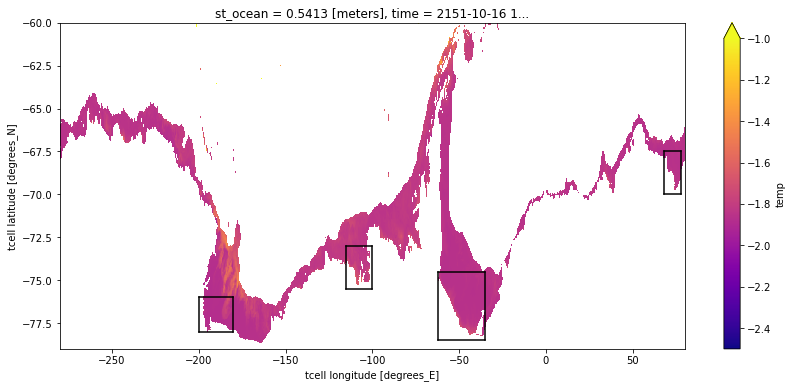

In [8]:
# first year only
start_time='2152-01-01'
end_time='2153-01-01'
lat_slice = slice(-79,-60)
lon_slice = slice(-280,80)
# read in T and S for region
temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp = temp.where(ht<1000)

# plot regions of interest for quick reference check
(temp[0,0,:,:]-273.15).plot(figsize=(14,6), cmap='plasma', vmin=-2.5, vmax=-1)
#amundsen
l,r = -115, -100
b,t = -75.5, -73
plt.plot([l,l],[b,t],c='k')
plt.plot([r,r],[b,t],c='k')
plt.plot([l,r],[b,b],c='k')
plt.plot([l,r],[t,t],c='k')
#amery IS
l,r = 68, 78
b,t = -70, -67.5
plt.plot([l,l],[b,t],c='k')
plt.plot([r,r],[b,t],c='k')
plt.plot([l,r],[b,b],c='k')
plt.plot([l,r],[t,t],c='k')
#south-west ross sea
l,r = -200, -180
b,t = -78, -76
plt.plot([l,l],[b,t],c='k')
plt.plot([r,r],[b,t],c='k')
plt.plot([l,r],[b,b],c='k')
plt.plot([l,r],[t,t],c='k')
#Southern weddell sea
l,r = -62, -35
b,t = -78.5, -74.5
plt.plot([l,l],[b,t],c='k')
plt.plot([r,r],[b,t],c='k')
plt.plot([l,r],[b,b],c='k')
plt.plot([l,r],[t,t],c='k')

plt.ylim(-79, -60)

plt.show()

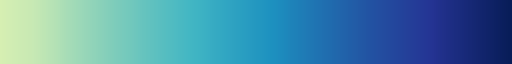

In [9]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('YlGnBu')
new_cmap = truncate_colormap(cmap, 0.2, 1)
new_cmap

In [10]:
bounds = {}
bounds['Ross Sea'] = (-200, -180, -78, -76)
bounds['Amery IS'] = (68, 78, -70, -67.5)
bounds['Weddell Sea'] = (-62, -35, -78.5, -74.5)
bounds['Amundsen Sea'] = (-115, -100, -75.5, -73)

Ross Sea (-200, -180, -78, -76)
Temp is 0.023688 GB


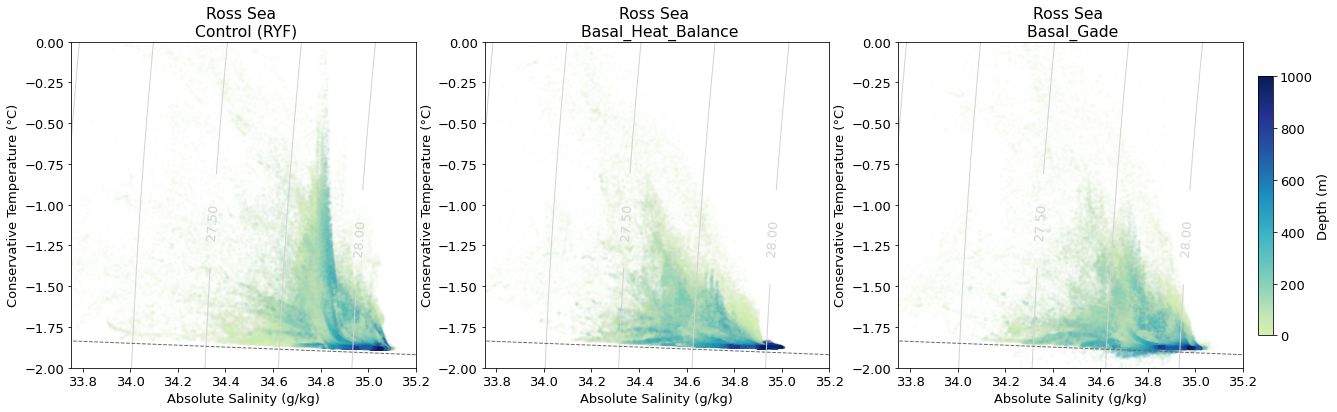

Amery IS (68, 78, -70, -67.5)
Temp is 0.01512 GB


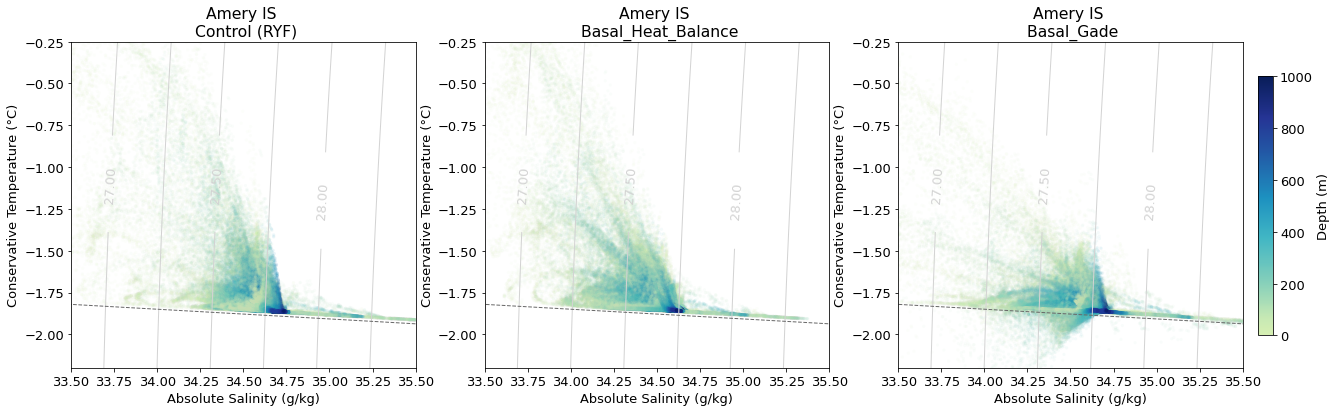

Weddell Sea (-62, -35, -78.5, -74.5)
Temp is 0.064638 GB


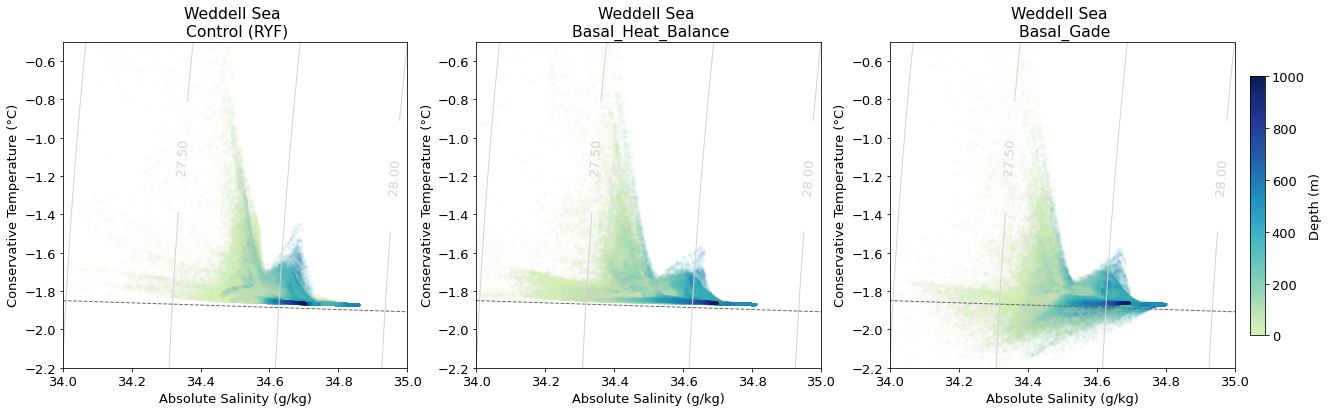

Amundsen Sea (-115, -100, -75.5, -73)
Temp is 0.022302 GB


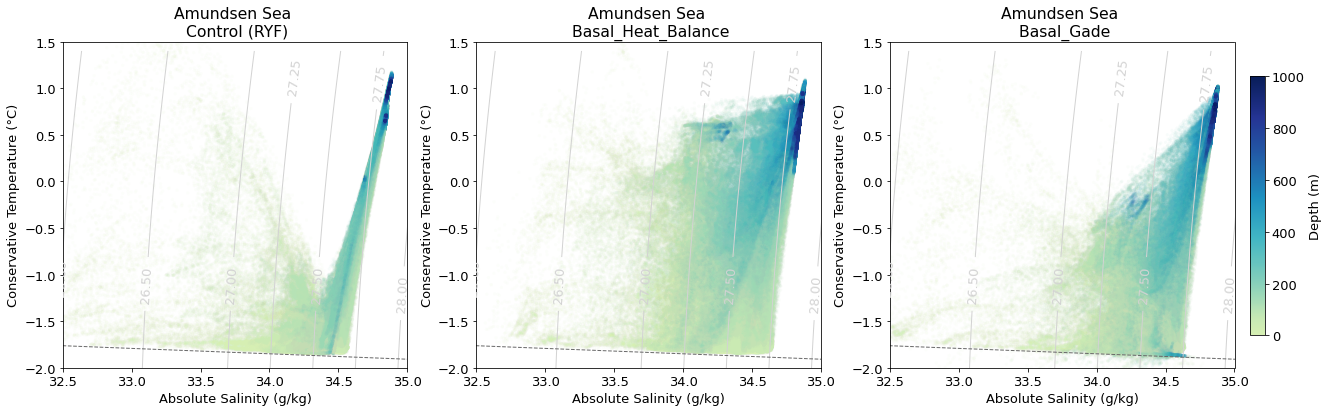

In [12]:
# third year only
start_time='2152-01-01'
end_time='2152-12-31'

for key in bounds:
    print(key, bounds[key])
    l,r,b,t = bounds[key]
    lat_slice = slice(b,t)
    lon_slice = slice(l,r)
    
    # read in T and S for region
    temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

    # create arrays for scatter colouring
    depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tfreezing_min_calv_2)
    depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)
    
    # plot figure
    scatter_colour = ['depth']#,'lat']
    s, alph, cmap = 10, 0.05, new_cmap

    sa = np.arange(32,35,0.01)
    t_func_l = -3.4*sa+115.9
    t_func_r1 = 4.5*sa-155.6#155.8
    t_func_r2 = 8*sa-277.3#.43

    for f in range(1):
        fig, axes, region = figure(key)
        if scatter_colour[f] == 'depth':
            axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            c = axes[1].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
            axes[2].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            #axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g - depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            plt.colorbar(c, cax = fig.add_axes([0.91, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')

        else:
            axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
            axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            plt.colorbar(c, cax = fig.add_axes([0.91, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

        axes[0].set_title(f'{key} \n Control (RYF)')
        axes[1].set_title(f'{key} \n Basal_Heat_Balance')
        axes[2].set_title(f'{key} \n Basal_Gade')
        
        if key == 'Ross Sea':
            for ax in axes.flatten():
                ax.set_xlim([33.75, 35.2])
                ax.set_ylim([-2, 0])
        elif key == 'Amery IS':
            for ax in axes.flatten():
                ax.set_xlim([33.5, 35.5])
                ax.set_ylim([-2.2, -0.25])
        elif key == 'Weddell Sea':
            for ax in axes.flatten():
                ax.set_xlim([34, 35])
                ax.set_ylim([-2.2, -0.5])
        else:
            for ax in axes.flatten():
                ax.set_xlim([32.5, 35])
                ax.set_ylim([-2, 1.5])
            
        plt.show()
        
        

# Old code

Quickly plot regions of interest for reference.

--> Probably want to restrict these much closer to coastline.

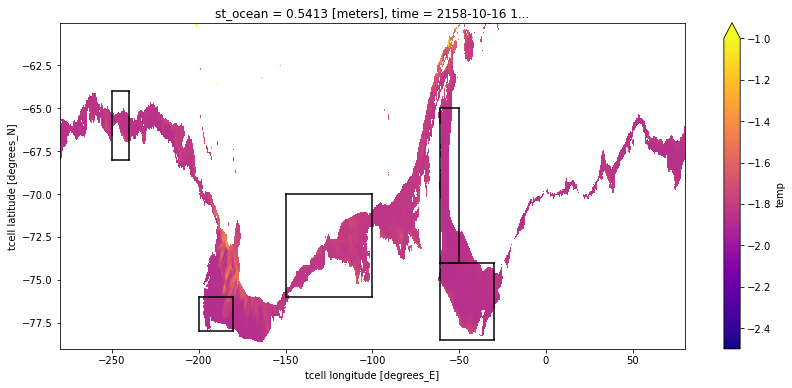

In [6]:
# first year only
start_time='2159-01-01'
end_time='2160-01-01'
lat_slice = slice(-79,-60)
lon_slice = slice(-280,80)
# read in T and S for region
temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp = temp.where(ht<1000)

# plot regions of interest for quick reference check
(temp[0,0,:,:]-273.15).plot(figsize=(14,6), cmap='plasma', vmin=-2.5, vmax=-1)
#amundsen
plt.plot([-150,-150],[-76,-70],c='k')
plt.plot([-100,-100],[-76,-70],c='k')
plt.plot([-150,-100],[-76,-76],c='k')
plt.plot([-150,-100],[-70,-70],c='k')
#ea
plt.plot([-250,-250],[-68,-64],c='k')
plt.plot([-240,-240],[-68,-64],c='k')
plt.plot([-250,-240],[-68,-68],c='k')
plt.plot([-250,-240],[-64,-64],c='k')
#ross sea
plt.plot([-200,-200],[-78,-76],c='k')
plt.plot([-180,-180],[-78,-76],c='k')
plt.plot([-200,-180],[-78,-78],c='k')
plt.plot([-200,-180],[-76,-76],c='k')
#Southern weddell sea
plt.plot([-61,-61],[-78.5,-74],c='k')
plt.plot([-30,-30],[-78.5,-74],c='k')
plt.plot([-61,-30],[-78.5,-78.5],c='k')
plt.plot([-61,-30],[-74,-74],c='k')
#western weddell sea
l,r,t,b= -61,-50,-65,-74
plt.plot([l,l],[b,t],c='k')
plt.plot([r,r],[b,t],c='k')
plt.plot([l,r],[b,b],c='k')
plt.plot([l,r],[t,t],c='k')

plt.show()

Now plot specific regions. 

### Amundsen Sea

#### Whole region

In [14]:
# first year only
start_time='2159-01-01'
end_time='2160-01-01'

# Amundsen Sea region
lat_slice = slice(-76,-70)
lon_slice = slice(-150,-100)
# read in T and S for region
temp, salt, temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

# create arrays for scatter colouring
#depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tfreezing_min_calv_2)
depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)

Temp is 0.17892 GB


In [15]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('YlGnBu')
new_cmap = truncate_colormap(cmap, 0.2, 1)

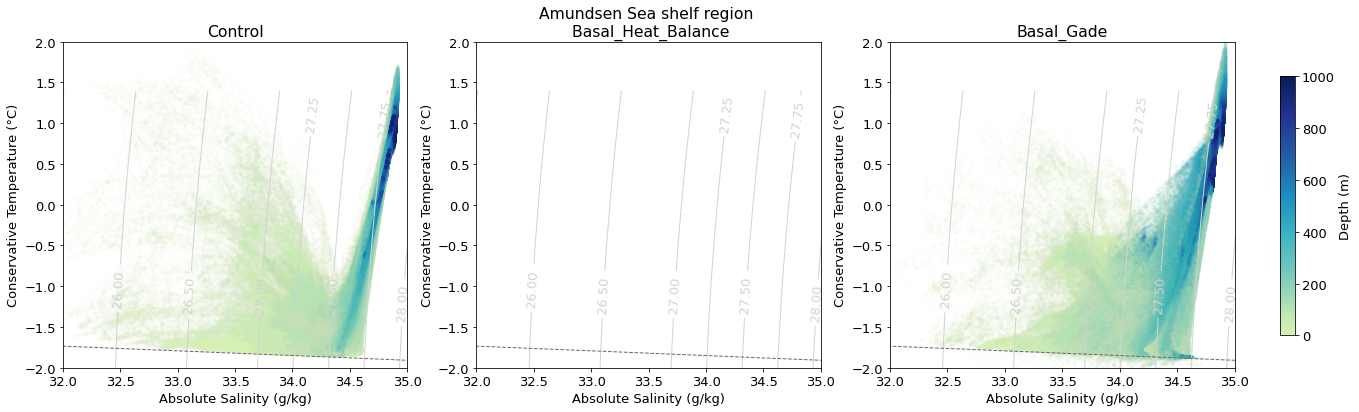

In [20]:
# plot figure
scatter_colour = ['depth']#,'lat']
s, alph, cmap = 10, 0.05, new_cmap

for f in range(1):
    fig, axes, region = figure('Amundsen Sea')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt,temp, c=depth_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        #axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[2].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        #axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g - depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        #axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control')
    axes[1].set_title(f'{region} shelf region \n Basal_Heat_Balance')
    axes[2].set_title(f'Basal_Gade')
    
    #axes[0].plot(sa,t_func_l,c='orange',lw=2)
    #axes[0].plot(sa,t_func_r1,c='orangered',lw=2)
    #axes[0].plot(sa,t_func_r2,c='green',lw=2)
    
    plt.show()

Plot where the T-S changes are in latitude, longitude space.

In [12]:
lat_tmp = t_tmp.copy(deep=True)
lon_tmp = t_tmp.copy(deep=True)


#for t in range(t_tmp.shape[0]):
#    print(f'time index is {t}')
#    for z in range(t_tmp.shape[1]):
#        print(z)
print(t_tmp.shape[2], t_tmp.shape[3])
for la in range(t_tmp.shape[2]):
    #print(f'lat index is {la}')
    for lo in range(t_tmp.shape[3]):
        lat_tmp[:,:,la,lo] = lat_tmp.yt_ocean[la]
        lon_tmp[:,:,la,lo] = lat_tmp.xt_ocean[lo]
        
z_tmp = t_tmp.copy(deep=True)
for z in range(t_tmp.shape[1]):
    z_tmp[:,z,:,:] = z_tmp.st_ocean[z]

NameError: name 't_tmp' is not defined

In [ ]:
# extract to 1D array
temp_change_points = np.ravel(t_tmp)
salt_change_points = np.ravel(s_tmp)
lat_change_points = np.ravel(lat_tmp)
lon_change_points = np.ravel(lon_tmp)
z_change_points = np.ravel(z_tmp)
print(temp_change_points.shape)

# replace values in lat and lon with NaNs where undefined
lat_change_points[np.isnan(temp_change_points )] = np.nan
lon_change_points[np.isnan(temp_change_points )] = np.nan
z_change_points[np.isnan(temp_change_points )] = np.nan

# remove NaNs
temp_change_points = temp_change_points[np.isfinite(temp_change_points)]
salt_change_points = salt_change_points[np.isfinite(salt_change_points)]
lat_change_points = lat_change_points[np.isfinite(lat_change_points)]
lon_change_points = lon_change_points[np.isfinite(lon_change_points)]
z_change_points = z_change_points[np.isfinite(z_change_points)]
print(temp_change_points.shape)

In [13]:
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import cmocean as cmo

def mercator_plot(axes, extent):
    
    salt_fig = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=slice(-80,-60)).sel(xt_ocean=slice(-200,-60))
    salt_fig = salt_fig.where(ht<1000)
    cb = axes.pcolormesh(salt_fig[0,0,:,:].xt_ocean, salt_fig[0,0,:,:].yt_ocean, salt_fig[0,0,:,:],
                    cmap=cmo.cm.haline, alpha=0.5, vmin=32, vmax=35, transform = ccrs.PlateCarree())    
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=0.8, color='grey', alpha=1, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14, 'color': 'k'}
    gl.ylabel_style = {'size': 14, 'color': 'k'}
    gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72, -71])
    axes.set_extent(extent, crs=ccrs.PlateCarree())
    plt.colorbar(cb, label='Salinity @ surface (psu)', extend='both')
    return

NameError: name 'lon_change_points' is not defined

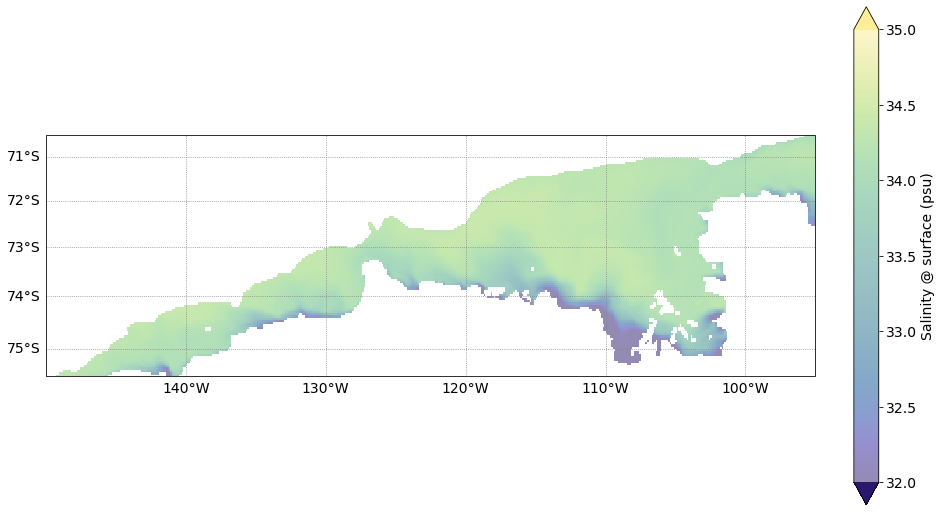

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(13,7))
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
ax = fig.add_subplot(spec1[0, 0], projection=ccrs.Mercator(central_longitude=-100))
mercator_plot(ax,[-150, -95, -75.5, -70.5])
cb = ax.scatter(lon_change_points,lat_change_points, 
           c=z_change_points, cmap=cmo.cm.matter,vmin=0, vmax=400,
           s=6, transform = ccrs.PlateCarree())
plt.colorbar(cb, label='Depth (m)', extend='max')
plt.show()

#### Inner-west shelf

In [12]:
# first year only
start_time='2151-01-01'
end_time='2152-01-01'

# Amundsen Sea region
lat_slice = slice(-76,-74)
lon_slice = slice(-110,-108)
# read in T and S for region
temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tfreezing_min_calv_2)
depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)

Temp is 0.0024192 GB


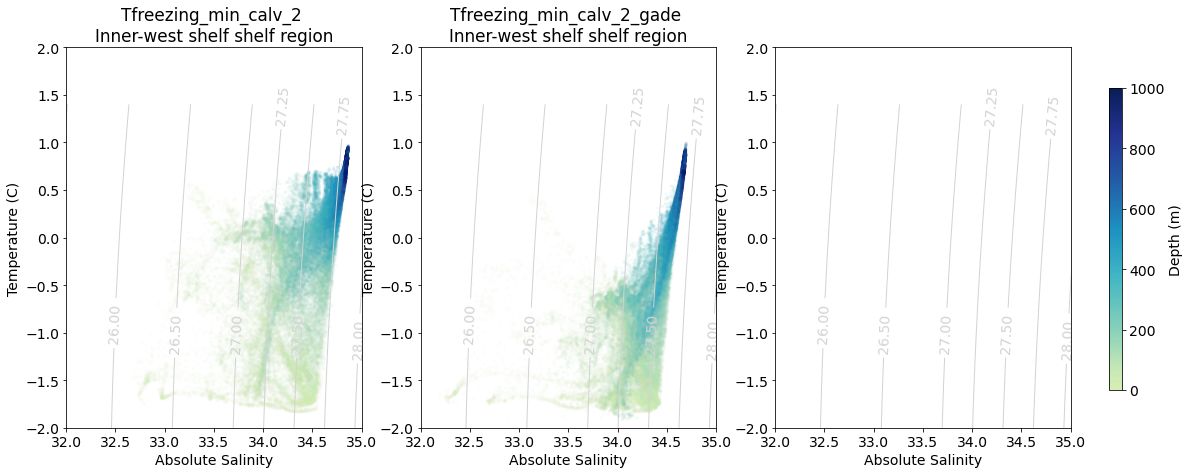

In [13]:
# plot figure
scatter_colour = ['depth']#,'lat']
s, alph, cmap = 10, 0.05, new_cmap

sa = np.arange(32,35,0.01)
t_func_l = -3.4*sa+115.9
t_func_r1 = 4.5*sa-155.6#155.8
t_func_r2 = 8*sa-277.3#.43

for f in range(1):
    fig, axes, region = figure('Inner-west shelf')
    
    if scatter_colour[f] == 'depth':
        #axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        axes[0].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        #axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g - depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')

    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Tfreezing_min_calv_2 \n{region} shelf region')
    axes[1].set_title(f'Tfreezing_min_calv_2_gade \n{region} shelf region')

    
    plt.show()

#### Inner-central shelf

In [18]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# Amundsen Sea region
lat_slice = slice(-76,-74)
lon_slice = slice(-108,-103)
# read in T and S for region
temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tfreezing_min_calv_2)
depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)

Temp is 0.006048 GB


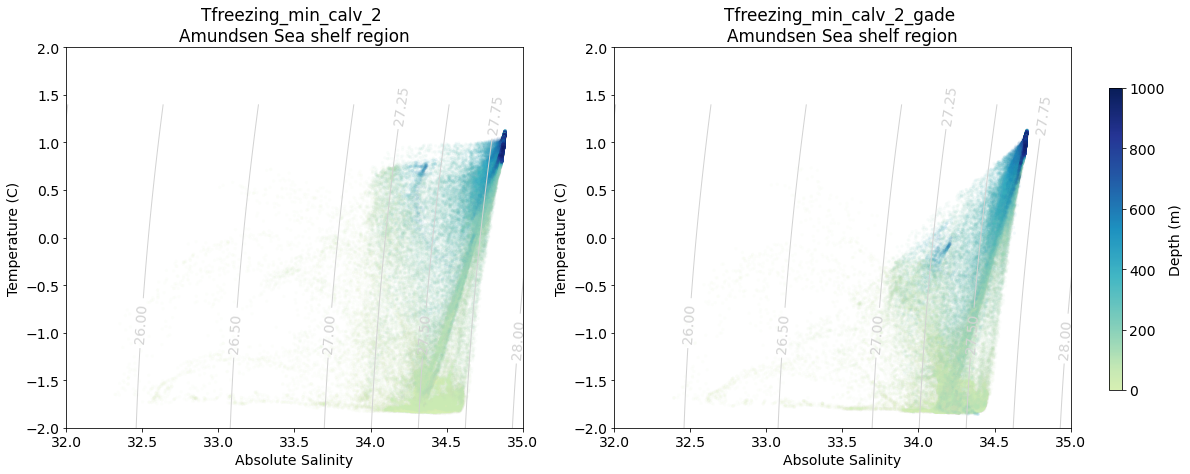

In [20]:
# plot figure
scatter_colour = ['depth']#,'lat']
s, alph, cmap = 10, 0.05, new_cmap

sa = np.arange(32,35,0.01)
t_func_l = -3.4*sa+115.9
t_func_r1 = 4.5*sa-155.6#155.8
t_func_r2 = 8*sa-277.3#.43

for f in range(1):
    fig, axes, region = figure('Amundsen Sea')
    
    if scatter_colour[f] == 'depth':
        #axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        axes[0].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        #axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g - depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')

    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Tfreezing_min_calv_2 \n{region} shelf region')
    axes[1].set_title(f'Tfreezing_min_calv_2_gade \n{region} shelf region')

    
    plt.show()

#### Inner-east shelf

In [21]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# Amundsen Sea region
lat_slice = slice(-76,-74)
lon_slice = slice(-103,-101)
# read in T and S for region
temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tfreezing_min_calv_2)
depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)

Temp is 0.0024192 GB


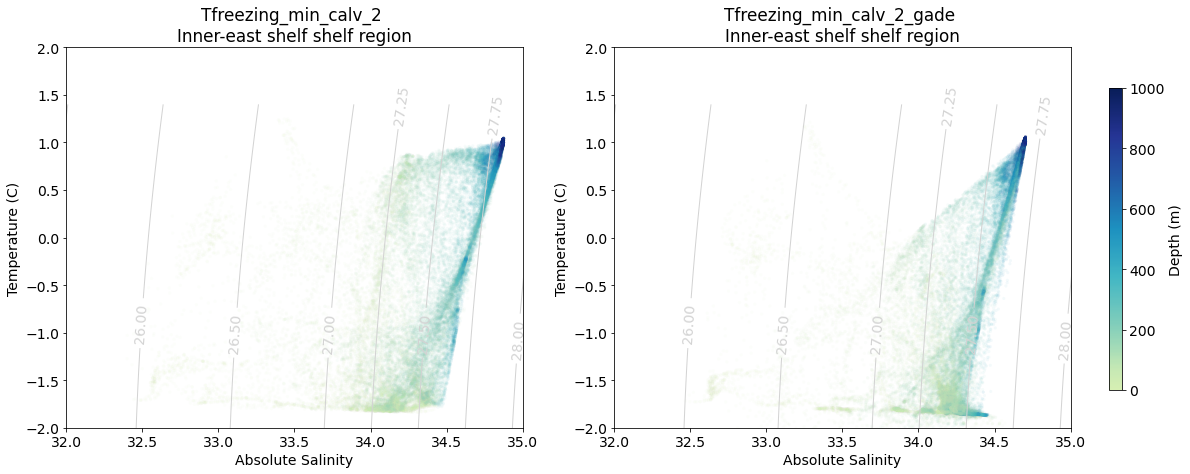

In [23]:
# plot figure
scatter_colour = ['depth']#,'lat']
s, alph, cmap = 10, 0.05, new_cmap

sa = np.arange(32,35,0.01)
t_func_l = -3.4*sa+115.9
t_func_r1 = 4.5*sa-155.6#155.8
t_func_r2 = 8*sa-277.3#.43

for f in range(1):
    fig, axes, region = figure('Inner-east shelf')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')

    else:
        axes[0].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')


    axes[0].set_title(f'Tfreezing_min_calv_2 \n{region} shelf region')
    axes[1].set_title(f'Tfreezing_min_calv_2_gade \n{region} shelf region')

    
    plt.show()

#### Central shelf

In [24]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# Amundsen Sea region
lat_slice = slice(-74,-73)
lon_slice = slice(-110,-101)
# read in T and S for region
temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tfreezing_min_calv_2)
depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)

Temp is 0.0052164 GB


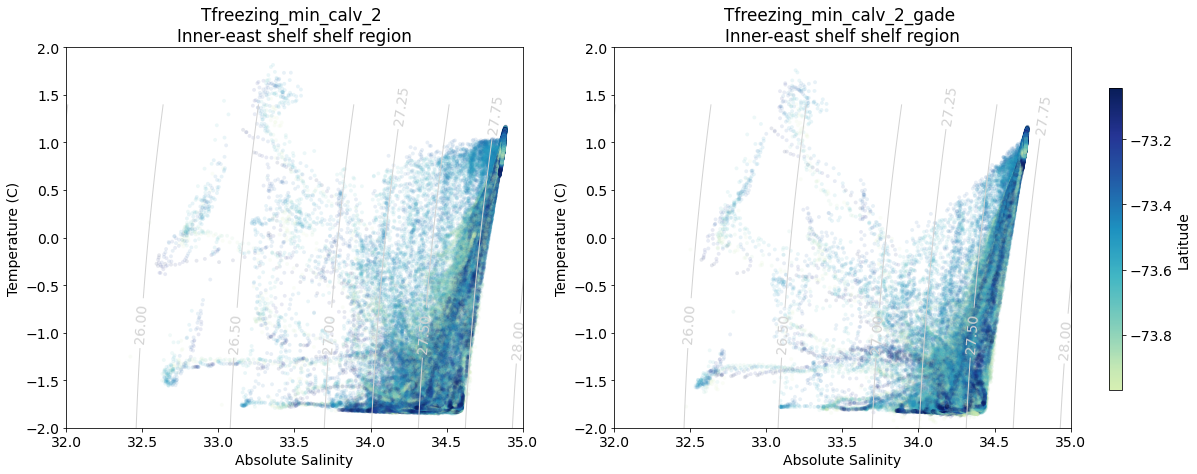

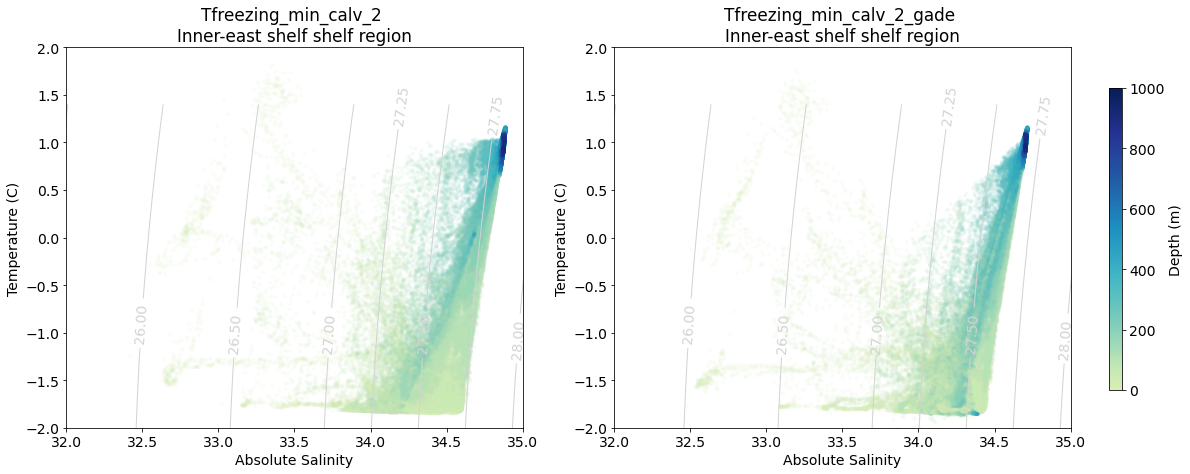

In [27]:
# plot figure
scatter_colour = ['lat','depth']
s, alph, cmap = 15, 0.1, new_cmap

for f in range(2):
    fig, axes, region = figure('Inner-east shelf')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')

    else:
        axes[0].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=lat_arr_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')


    axes[0].set_title(f'Tfreezing_min_calv_2 \n{region} shelf region')
    axes[1].set_title(f'Tfreezing_min_calv_2_gade \n{region} shelf region')

    
    plt.show()

#### Outer shelf

In [47]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# Amundsen Sea region
lat_slice = slice(-73,-71)
lon_slice = slice(-110,-101)
# read in T and S for region
temp, salt, temp_Tf_min_s0, salt_Tf_min_s0 = read_and_convert_TS(lat_slice,lon_slice, start_time, end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tf_min_s0)

Temp is 0.0108864 GB


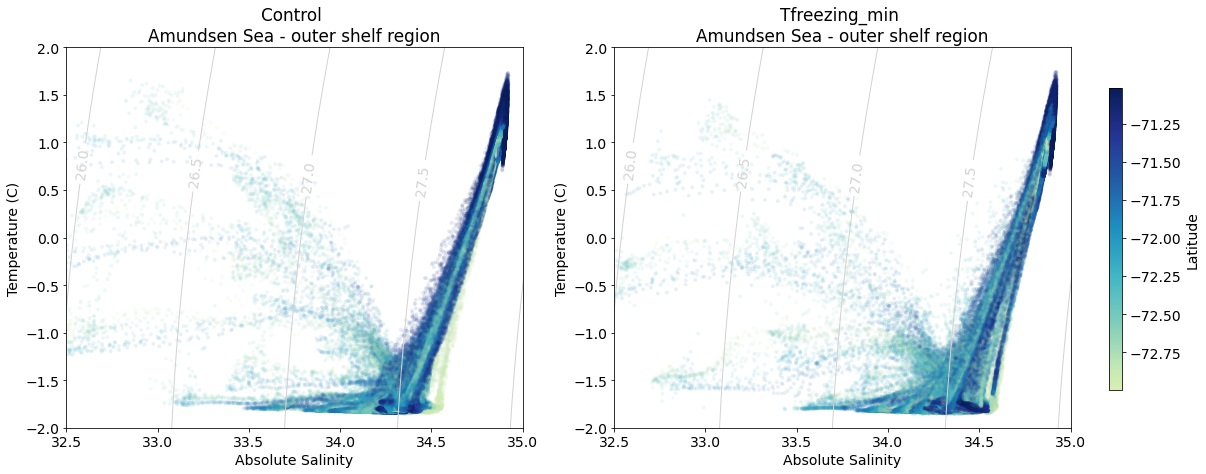

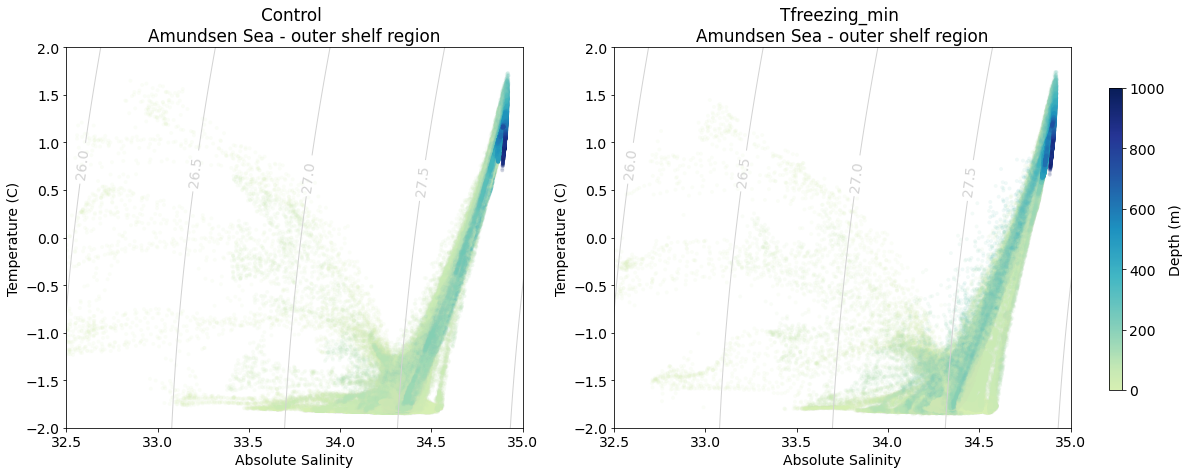

In [48]:
# plot figure
scatter_colour = ['lat','depth']
s, alph, cmap = 15, 0.1, new_cmap

for f in range(2):
    fig, axes, region = figure('Amundsen Sea - outer shelf')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control \n{region} region')
    axes[1].set_title(f'Tf_min \n{region} region')
    for i in range(2):
        #axes[i].set_ylim([-2,1.5])
        axes[i].set_xlim([32.5,35])

    plt.show()

### East Antarctic Section

In [49]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# East Antarctic region
lat_slice = slice(-68,-62)
lon_slice = slice(-250,-240)
# read in T and S for region
temp, salt, temp_Tf_min_s0, salt_Tf_min_s0 = read_and_convert_TS(lat_slice,lon_slice, start_time, end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tf_min_s0)

Temp is 0.034776 GB


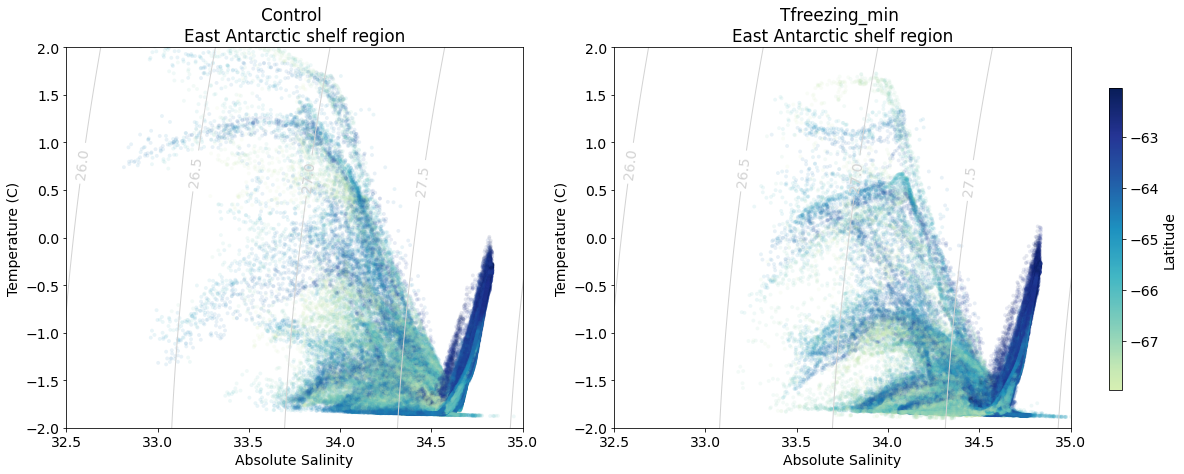

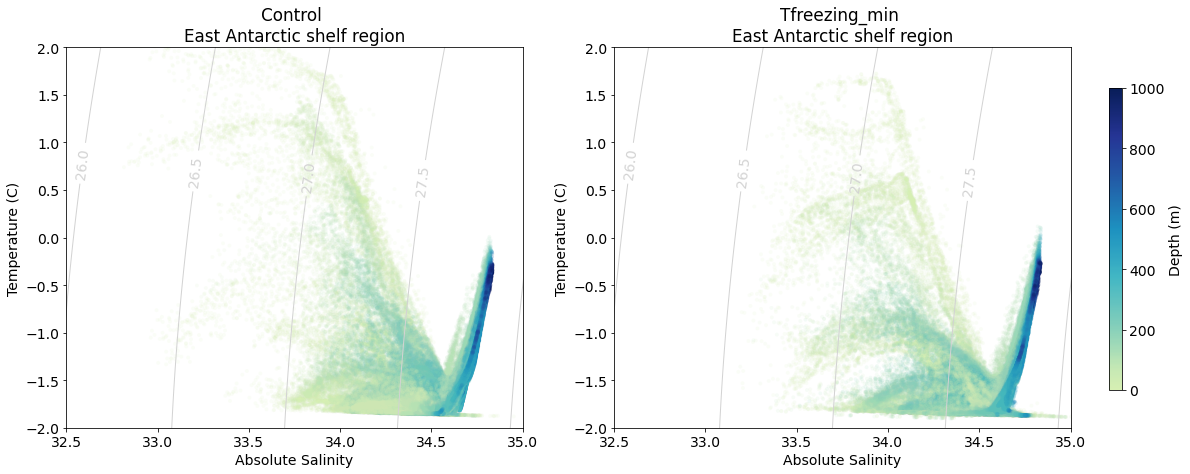

In [50]:
# plot figure
scatter_colour = ['lat','depth']
s, alph, cmap = 15, 0.1, new_cmap

for f in range(2):
    fig, axes, region = figure('East Antarctic shelf')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control \n{region} region')
    axes[1].set_title(f'Tf_min \n{region} region')
    for i in range(2):
        #axes[i].set_ylim([-2,1.5])
        axes[i].set_xlim([32.5,35])

    plt.show()

### Ross Sea Section

In [52]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# East Antarctic region
lat_slice = slice(-78,-76)
lon_slice = slice(-200,-180)
# read in T and S for region
temp, salt, temp_Tf_min_s0, salt_Tf_min_s0 = read_and_convert_TS(lat_slice,lon_slice, start_time, end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tf_min_s0)

Temp is 0.023688 GB


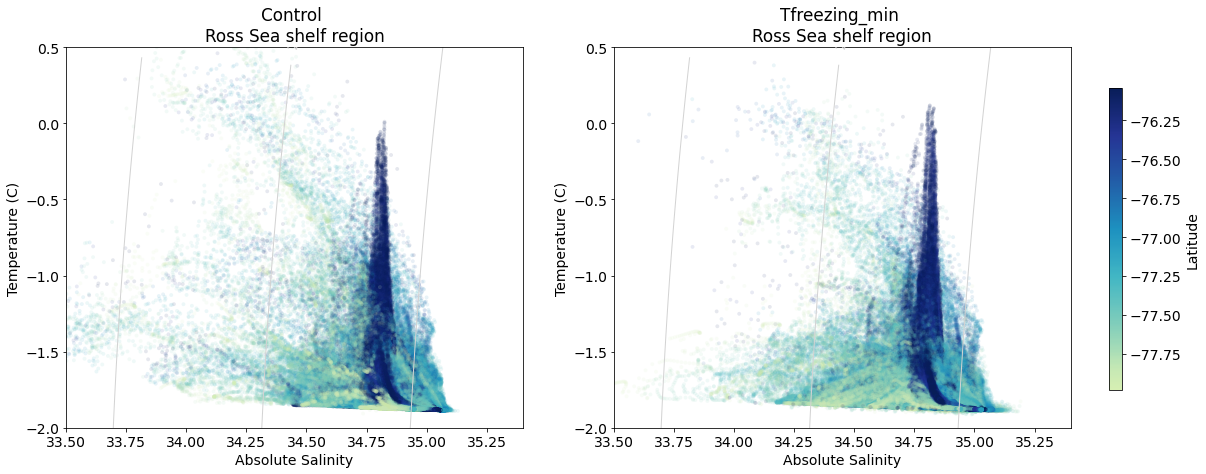

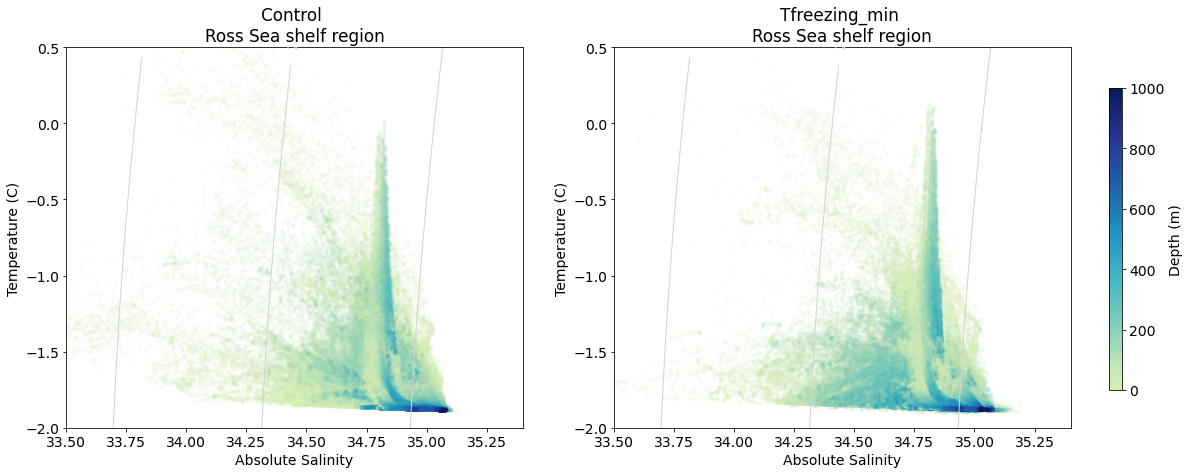

In [53]:
# plot figure
scatter_colour = ['lat','depth']
s, alph, cmap = 15, 0.1, new_cmap

for f in range(2):
    fig, axes, region = figure('Ross Sea shelf')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control \n{region} region')
    axes[1].set_title(f'Tf_min \n{region} region')
    for i in range(2):
        axes[i].set_ylim([-2,0.5])
        axes[i].set_xlim([33.5,35.4])


    plt.show()

### Southern Weddell Sea

In [54]:
# first year only
start_time='2150-01-01'
end_time='2151-01-01'

# East Antarctic region
lat_slice = slice(-78.5,-74)
lon_slice = slice(-61,-30)
# read in T and S for region
temp, salt, temp_Tf_min_s0, salt_Tf_min_s0 = read_and_convert_TS(lat_slice,lon_slice, start_time, end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tf_min_s0)

Temp is 0.0835884 GB


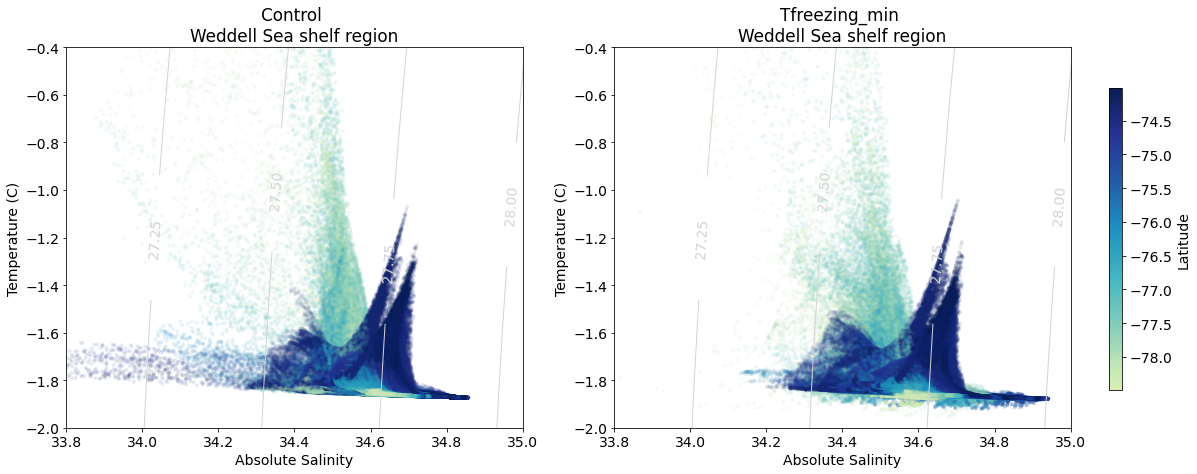

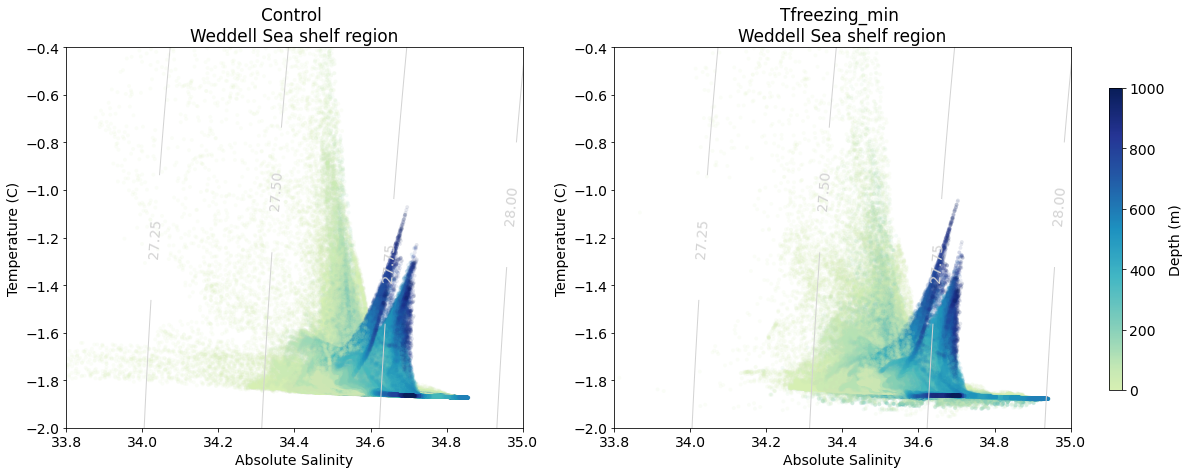

In [62]:
# plot figure
scatter_colour = ['lat','depth']
s, alph, cmap = 15, 0.1, new_cmap

for f in range(2):
    fig, axes, region = figure('Weddell Sea shelf')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control \n{region} region')
    axes[1].set_title(f'Tf_min \n{region} region')
    for i in range(2):
        axes[i].set_ylim([-2,-0.4])
        axes[i].set_xlim([33.8,35])


    plt.show()

### Western Weddell Sea

In [65]:
# first year only
start_time='2150-01-01'
end_time='2152-01-01'

# East Antarctic region
lat_slice = slice(-74,-65)
lon_slice = slice(-61,-50)
# read in T and S for region
temp, salt, temp_Tf_min_s0, salt_Tf_min_s0 = read_and_convert_TS(lat_slice,lon_slice, start_time, end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tf_min_s0)

Temp is 0.0590436 GB


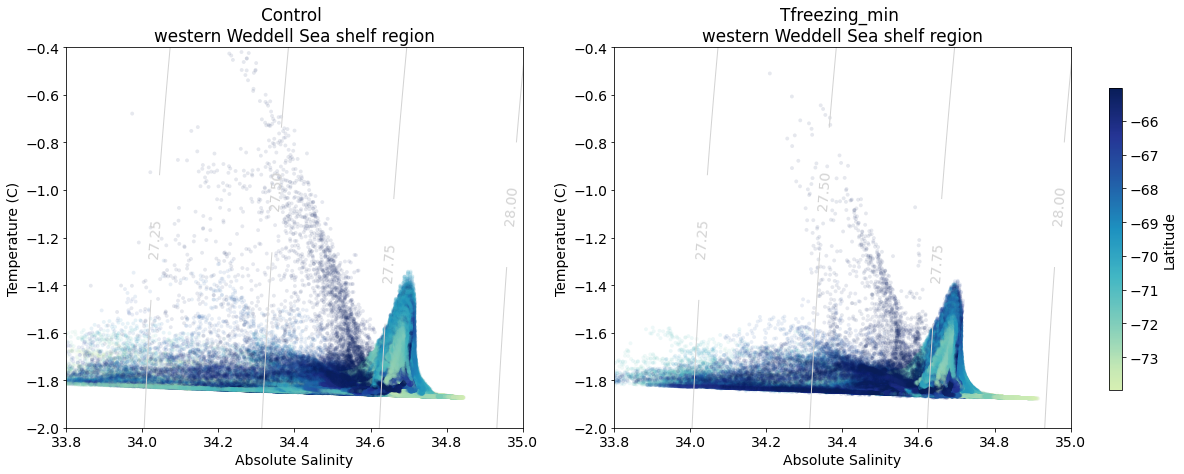

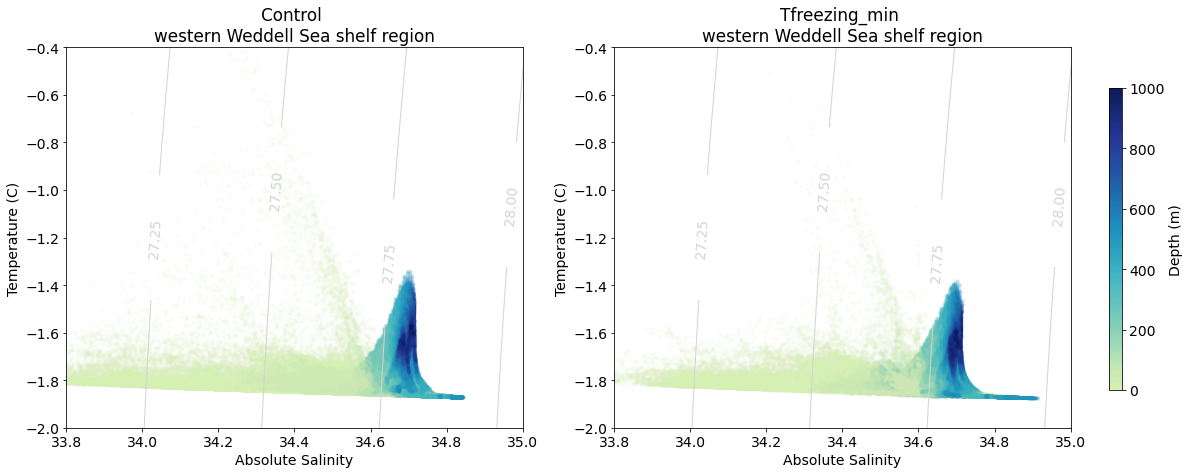

In [66]:
# plot figure
scatter_colour = ['lat','depth']
s, alph, cmap = 15, 0.1, new_cmap

for f in range(2):
    fig, axes, region = figure('western Weddell Sea shelf')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tf_min_s0,temp_Tf_min_s0, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control \n{region} region')
    axes[1].set_title(f'Tf_min \n{region} region')
    for i in range(2):
        axes[i].set_ylim([-2,-0.4])
        axes[i].set_xlim([33.8,35])


    plt.show()